In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

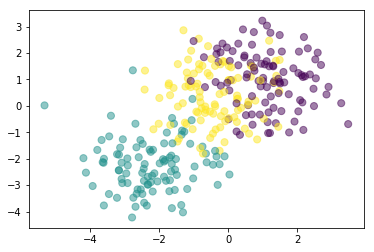

In [2]:
X,y = make_blobs(center_box = (-3,3),n_samples = 300)
plt.scatter(X[:,0],X[:,1], c = y, s = 50, alpha = 0.5)

In [3]:
class KMeans:
    
    def __init__(self, k):
        self.k = k
    
    def get_clusters(self,X):
        
        distances = np.zeros((len(X), self.k))
        for center in range(len(self.centers)):
            distances[:,center] = ((X-self.centers[center,:])**2).sum(axis = 1)
            
        return np.argmin(distances,axis = 1)
    
    
    def compute_new_centers(self,X,labels):
        
        for center in range(len(self.centers)):
            tmp = X[labels == center,:]
            if len(tmp) == 0:
                continue
            self.centers[center,:] = tmp.mean(axis = 0)
    
    def fit(self,X):
        
        self.centers = np.random.randn(self.k, X.shape[1])
        labels = self.get_clusters(X)
        previous_clusters = np.zeros_like(labels)
        #print(self.centers)
        
        while not np.array_equal(previous_clusters,labels):
            
            previous_clusters = labels.copy()
            self.compute_new_centers(X, labels)
            labels = self.get_clusters(X)
            #print(self.centers)
            
    def predict(self,X):
        return self.get_clusters(X)
                  

In [4]:
testkmeans = KMeans(3)

In [5]:
testkmeans.fit(X)

In [6]:
preds = testkmeans.predict(X)

In [7]:
testkmeans.centers

array([[ 0.95869254,  1.34294676],
       [-2.49277569, -2.43549094],
       [-0.50467055, -0.32309138]])

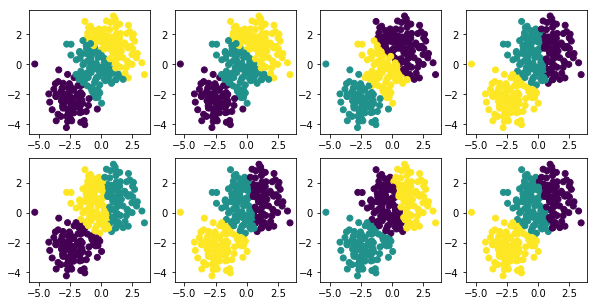

In [8]:
fig, ax = plt.subplots(2,4, figsize=(10,5))
ax = ax.flatten()

for a in ax:
    testkmeans = KMeans(3)
    testkmeans.fit(X)
    preds = testkmeans.predict(X)
    a.scatter(X[:,0],X[:,1], c = preds)

As can be seen above kmeans doesn't always converge to the same clusters. It depends on the random initialization of the centers. As a solution, we could repeat this process several times and accept the answer with the lowest sum of distances to the nearest center.

An interesting idea is that like most supervised machine learning models, sometimes we want to know the probability of being in a class as opposed to just the prediction. Kmeans can be adapted in a similar fashion by considering the distances of a point to each cluster center to assign this probability. 

In [9]:
class SoftKMeans:
    
    def __init__(self, k, beta = 1):
        self.k = k
        self.beta = beta
        self.costs = []
        
    def get_responsibilities(self,X):
        
        distances = np.zeros((len(X), self.k))
        for center in range(len(self.centers)):
            distances[:,center] = ((X-self.centers[center,:])**2).sum(axis = 1)
        
        exp_distances = np.exp(-self.beta*distances)
        responsibilities = exp_distances/exp_distances.sum(axis = 1).reshape(-1,1)
        
        return responsibilities
    
    
    def compute_new_centers(self,X,responsibilities):
        
        for center in range(self.k):
            self.centers[center,:] = (responsibilities[:,center].reshape(-1,1)/responsibilities[:,center].sum()).T.dot(X)
    
    def get_cost(self,X,responsibilities):
        distances = np.zeros((len(X), self.k))
        for center in range(self.k):
            distances[:,center] = ((X-self.centers[center,:])**2).sum(axis = 1)
            
        costs = distances*responsibilities
        self.costs.append(costs.sum())
        return(costs.sum())
        
    
    def fit(self,X):
        
        self.centers = np.random.randn(self.k, X.shape[1])
        responsibilities = self.get_responsibilities(X)
        previous_cost = np.Inf
        cost = self.get_cost(X,responsibilities)
        while (previous_cost - cost) > .001 :
            previous_cost = cost
            self.compute_new_centers(X, responsibilities)
            responsibilities = self.get_responsibilities(X)
            cost = self.get_cost(X,responsibilities)
            
            
    def predict(self,X):
        responsibilities = self.get_responsibilities(X)
        return np.argmax(responsibilities,axis = 1), responsibilities
                  

In [10]:
softkmeans = SoftKMeans(3)
softkmeans.fit(X)

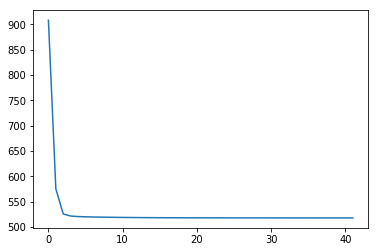

In [11]:
plt.plot(softkmeans.costs)

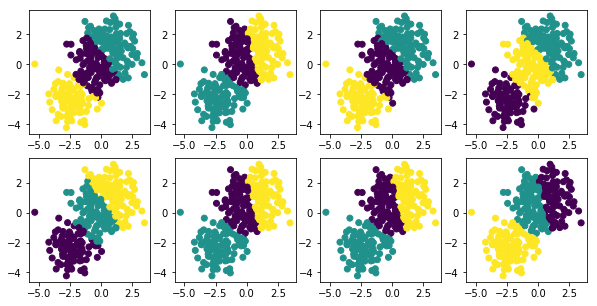

In [12]:
fig, ax = plt.subplots(2,4, figsize=(10,5))
ax = ax.flatten()

for a in ax:
    softkmeans = SoftKMeans(3)
    softkmeans.fit(X)
    preds, reponsibilities = softkmeans.predict(X)
    a.scatter(X[:,0],X[:,1], c = preds)

In this case we know the correct K. What if we didn't?

Text(0.5,1,'K vs Costs')

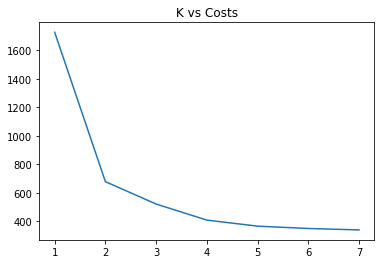

In [13]:
klist = list(range(1,8))
costs = []

for k in klist:
    softkmeans = SoftKMeans(k)
    softkmeans.fit(X)
    costs.append(softkmeans.costs[-1])
    
plt.plot(klist, costs)
plt.title('K vs Costs')

We see a fast decrease in costs from k = 1 to 2, followed by a steady decline to k=4, followed by a leveling out of the costs. In this case we may choose k = 2 or 4. Although the data was generated with k=3, there is obvious overlapping of the data, making it look like it could have been generated from a different k != 3.